# Отвечаемость aka First Reply Time

Задача: https://repetitors.info/admin/aforum/?t=155229

- В исследовании участвуют только спецы, зарегистрировавшиеся с 1 января 2020.
- Смотрим только ЛГ заказы.
- Учитывается только первый ответ спеца на приглашение (если была дальнейшая переписка, то она уже не учитывается).
- Пока не учитываем отмену заказа и выбор клиентом спеца.

### Важные детали:

Не учитываются заказы, в которых спец получил приглашение по ссылке - проект [Бесплатный профи](https://repetitors.info/admin/aforum/?t=151677). Там отклик от лица спеца отправляется автоматически. И это не отражает реальную отвечаемость спеца, потому что:
- Если у спеца ТОЛЬКО автоматические ответы и мы поставим ему среднюю отвечаемость "менее минуты", то клиент будет ожидать, что ему ответят быстро. Но это не так.
- Если спец отвечает вообще-то очень долго, но у него много авто-откликов, с заниженным средним мы не дадим ему правильную обратную связь "чувак, ты медленно отвечаешь в чатах, обрати внимание".<br>

(исключаем заказы, где было событие o_pchosen_free)

### Что хотим посчитать:
1. Процент отвеченных запросов (приглашений) клиента
2. Процент отвеченных положительно (отклик) запросов клиента
3. Среднее время ответа на запрос (приглашение) клиента

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [71]:
import math
import pandas
import statistics
from copy import deepcopy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [93]:
def percentile(N, percent, key=lambda x: x):
    if not N:
        return None
    k = (len(N) - 1) * percent
    f = math.floor(k)
    c = math.ceil(k)
    if f == c:
        return key(N[int(k)])
    d0 = key(N[int(f)]) * (c - k)
    d1 = key(N[int(c)]) * (k - f)
    return d0 + d1

def avg(data):
    if len(data) == 0:
        print 'No data'
        return 
    return round(sum(data) * 1.0 / len(data), 2)

def show_usual_stats(data):
    if len(data) == 0:
        print 'No data'
        return 
    data = sorted(data)
    print "Percentile 25% = ", percentile(data, 0.25)
    print "Percentile 50% = ", percentile(data, 0.5)
    print "Percentile 75% = ", percentile(data, 0.75)
    print "Percentile 95% = ", percentile(data, 0.95)
    print "\nAverage = ", round(sum(data) * 1.0 / len(data), 2)
    print "MAX = ", max(data)
    print "Data len: ", len(data)

In [134]:
column_names = ['order_city_id', 'project_name', 'prep_id', 'prep_dt', 'order_id', 
                'invite_id', 'invite_dt', 'invite_txt', 'invite_code', 
                'answer_id', 'answer_dt', 'answer_txt', 'answer_code']

df = pandas.read_csv('invites_answers_events.tsv', delimiter='\t', header=None, names = column_names, 
                     parse_dates = ['prep_dt', 'invite_dt', 'answer_dt'])
print "Число строк: ", len(df)
df.head()

Число строк:  73504


,order_city_id,project_name,prep_id,prep_dt,order_id,invite_id,invite_dt,invite_txt,invite_code,answer_id,answer_dt,answer_txt,answer_code
0,sochi.mstr,«МастерДел»,7774V,2020-01-23,26780723,1373455745,2020-03-10 22:04:07,NaN,o_pchosen,1.373464e+09,2020-03-10 22:13:47,<div prch=7040>Не подходит бюджет</div>,r_order_refused
1,smolensk.krst,«Крэйс–Мастерс»,A-7,2020-01-13,26594715,1414247678,2020-04-29 12:15:19,NaN,o_pchosen,NaN,NaT,NaN,NaN
2,chechnya-dmstf,Новые вертикали,AAA63,2020-01-08,26947517,1381135170,2020-03-17 21:45:11,NaN,o_pchosen,NaN,NaT,NaN,NaN
3,penza.mstr,«МастерДел»,AAA70,2020-02-01,26063163,1337092178,2020-02-10 13:57:02,NaN,o_pchosen,1.337132e+09,2020-02-10 14:15:56,"<b>ev_code=r_zayavka, cancel_dt=2020-03-08 19:...",r_zayavka0
4,penza.mstr,«МастерДел»,AAA70,2020-02-01,26063163,1337092178,2020-02-10 13:57:02,NaN,o_pchosen,1.371271e+09,2020-03-08 19:56:11,"<b>ev_code=r_order_refused, cancel_dt=2020-04-...",r_order_refused0


## Сколько всего препов получают приглашения от клиента
Под приглашениями имеются в виду нажатия на кнопку "Предложить заказ" и "Написать сообщение"<br><br>

Чтобы понимать масштаб анализируемых заказов: <br>
Всего __29% заказов__ имеют хотя бы 1 приглашение.

In [5]:
print 'Число уникальных препов за период: ', df.prep_id.nunique()

Число уникальных препов за период:  22248


Статистика числа приглашений на 1 препа:
Percentile 25% =  1.0
Percentile 50% =  2.0
Percentile 75% =  3.0
Percentile 95% =  10.0

Average =  3.3
MAX =  654
Data len:  22248


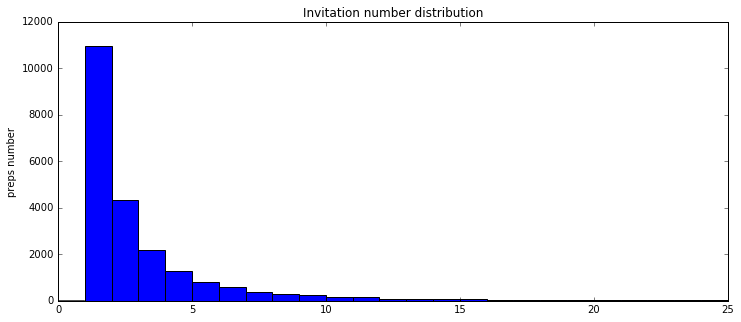

In [46]:
print 'Статистика числа приглашений на 1 препа:'
show_usual_stats(df.groupby(['prep_id'])['invite_id'].count())

plt.figure(figsize=(12,5))
df.groupby(['prep_id'])['invite_id'].count().plot.hist(bins = 25, range = (0,25))
plt.title("Invitation number distribution")
plt.ylabel('preps number')
plt.show()

В гистограмме намеренно отрезан длиннющий хвост, потому что иначе не видно, что слева.

In [8]:
print 'Препы, у которых максимальное количество приглашений:'
print df.groupby(['prep_id'])['invite_id'].count().sort_values(ascending=False)[:10]

Препы, у которых максимальное количество приглашений:
prep_id
OzerovaZB2       654
ErshovAS14       249
KarimovSR4       209
VaravkaVV2       198
MaltsevaAA29     180
FrolovRO2        166
IvanovaAU48      161
ShastinAV        161
KomissarovaVI    157
ErmakovaIM3      150
Name: invite_id, dtype: int64


Очень подозрительная OzerovaZB2 (маникюр) - целых 654 приглашения. А отправила она всего 38 заявок.<br>
Посмотрим на неё поближе.

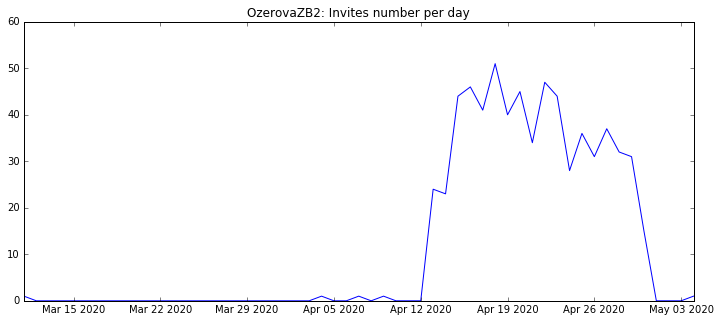

In [10]:
ozerova = df[df['prep_id'] == 'OzerovaZB2']
ozerova['invite_dt'] = ozerova['invite_dt'].dt.date

ozerova_invites_per_day = []
dates = [ozerova['invite_dt'].min() + timedelta(n) for n in range(55)]
for single_date in dates: 
    ozerova_invites_per_day.append(ozerova[ozerova['invite_dt'] == single_date]['invite_id'].count()) 

plt.figure(figsize=(12,5))
plt.plot(dates, ozerova_invites_per_day)
plt.title('OzerovaZB2: Invites number per day')
plt.show()

**Загадка:** <br> Что случилось 13 апреля, после чего Озёрова стала получать по 40-50 приглашений в день? <br>
**Отгадка:** <br> 
С 13 апреля в ранжировании стали давать сильный буст спецам, у которых указан "web" в анкете. А Озёрова - одна из немногих маникюрщиц, кто якобы оказывает услуги дистанционно. Поэтому она резко оказалась в топе и её стали выбирать благодаря повышенному спросу. <br>
Этот баг оперативно поправили 30 апреля.

In [11]:
df_preps_invites_count = df.groupby(['prep_id'])['invite_id'].count()
print 'Процент препов, у которых всего 1 приглашение: ', \
        round(len(df_preps_invites_count[df_preps_invites_count == 1])*100.0/df.prep_id.nunique(), 2), '%'

Процент препов, у которых всего 1 приглашение:  49.33 %


## % отвеченных приглашений


In [12]:
## TESTING
# prep_id = 'kosorukovAA4'
# df[df['prep_id'] == prep_id]['answer_id'].isnull().sum() * 100.0 / df[df['prep_id'] == prep_id]['order_id'].count()

In [13]:
df_preps_answers_count = df[df['answer_id'] > 0].groupby(['prep_id'])['order_id'].count()
df_preps_answers_percent = df_preps_answers_count * 100.0 / df_preps_invites_count

In [14]:
def show_hist_of_answer_percent(INVITES_N = 1):
    answers_percent_list = []
    for prep_id in df_preps_invites_count[df_preps_invites_count >= INVITES_N].index:
        if df_preps_answers_percent[prep_id] > 0:
            answers_percent_list.append(df_preps_answers_percent[prep_id])
        else:
            answers_percent_list.append(0)

    show_usual_stats(answers_percent_list)
    plt.figure(figsize=(12,5))
    plt.hist(answers_percent_list, bins = 25)
    plt.show()

Смотрим препов, у которых хотя бы 1 приглашение (просто чтобы понять, какой беспорядок тут в распределении).<br>
- Больше половины препов вообще не отвечают на приглашения.<br>
- Видим небольшой пик на 50% (во многом это те, у кого 2 приглашения и 1 из них отвечено).<br>
- Пик на 100% (во многом это те, у кого 1 приглашение и оно отвечено).

Percentile 25% =  0.0
Percentile 50% =  0.0
Percentile 75% =  66.6666666667
Percentile 95% =  100.0

Average =  29.77
MAX =  100.0
Data len:  22248


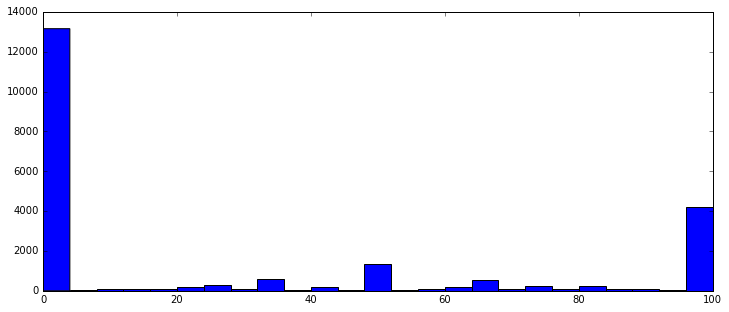

In [15]:
show_hist_of_answer_percent(1)

Теперь смотрим препов, у которых хотя бы 5 приглашений. (таких 14.5%)

Percentile 25% =  5.88235294118
Percentile 50% =  40.0
Percentile 75% =  71.4285714286
Percentile 95% =  100.0

Average =  41.41
MAX =  100.0
Data len:  3475


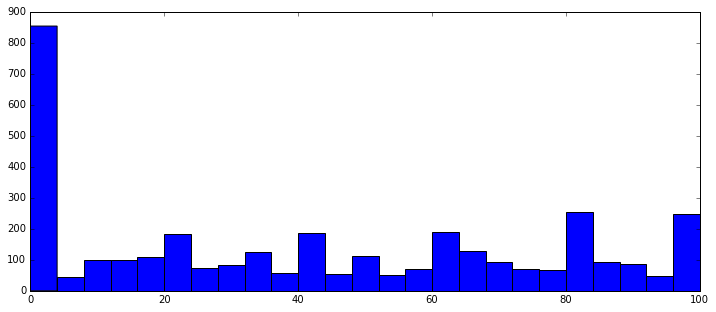

In [16]:
show_hist_of_answer_percent(5)

Теперь смотрим препов, у которых хотя бы 20 приглашений. (таких 1.5%)<br>
Здесь с большой натяжкой можно увидеть гаусса справа. <br>
То есть, из тех препов, кто получает от 20 приглашений, есть относительно большая группа тех, кто вообще не отвечает (отвечаемость = 0%), и большая группа тех, у кого высокая отвечаемость (более 65%). 

Percentile 25% =  23.5294117647
Percentile 50% =  61.5384615385
Percentile 75% =  82.1428571429
Percentile 95% =  95.0487804878

Average =  53.72
MAX =  100.0
Data len:  393


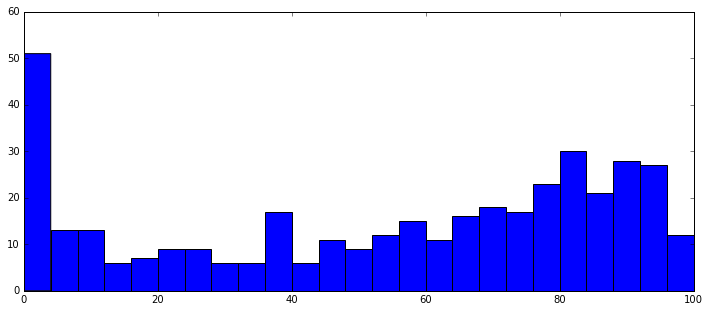

In [17]:
show_hist_of_answer_percent(20)

In [49]:
# какой % препов, получивших хотя бы N приглашений?
# N = 20
# round(len(df_preps_invites_count[df_preps_invites_count >= N])*100.0/df.prep_id.nunique(), 2)

Попробовала посчитать то же самое на выборке препов, зарегистрировавшихся с 1 января по 1 апреля (1 марта), <br>
учитывать только тех, у кого было достаточно времени, чтобы получить хотя бы 1 приглашение. <br>
Но по ним картинка очень мало отличается.


In [19]:
# берем выборку препов, зарегистрировавшихся с 2020-01-01 по 2020-04-01
# print len(df[df['prep_dt'] < '2020-04-01'].groupby(['prep_id']).count())
# 18284

# df = df[df['prep_dt'] < '2020-03-01']
##  ...

## Среднее время ответа по препам

Оставляем в табличке только время первого приглашения и время первого ответа на него (приглашения без ответа не учитываются).<br>
Считаем разницу между приглашением и ответом, записываем в минутах

In [20]:
df_answered_invites = df[df['answer_id'] > 0]
df_first_invites = df_answered_invites.groupby(['prep_id', 'order_id', 'invite_dt'])['invite_dt'].agg(['min'])
df_first_answers = df_answered_invites.groupby(['prep_id', 'order_id', 'invite_dt'])['answer_dt'].agg(['min'])

df_answers_diffs = df_first_answers - df_first_invites
df_answers_diffs['minutes_diff'] = df_answers_diffs['min'].dt.total_seconds() / 60
df_answers_diffs['minutes_diff'] = df_answers_diffs['minutes_diff'].round(1)
df_answers_diffs[5:11]

min  minutes_diff
prep_id            order_id invite_dt                                 
AbaevDA2           27778486 2020-05-05 10:33:05 00:04:39           4.6
AbaevEA            27144029 2020-03-28 08:25:29 05:48:15         348.2
AbakargadzhievaDSh 27250774 2020-04-04 15:37:27 00:28:38          28.6
AbakumovAK         27675550 2020-04-28 14:37:58 04:34:26         274.4
AbankinaAD         26185151 2020-02-15 20:32:18 10:39:47         639.8
                   27065105 2020-03-23 18:25:39 00:03:04           3.1

In [21]:
median_answer_time = df_answers_diffs.groupby(level = 0).median()
mean_answer_time = df_answers_diffs.groupby(level = 0).mean()

Распределение среднего и медианного времени ответов (отрезаем хвост после 100)
Percentile 25% =  [ 22.6]
Percentile 50% =  [ 80.55]
Percentile 75% =  [ 706.175]
Percentile 95% =  [ 10487.185]

Average =  2179.38
MAX =  [ 131330.]
Data len:  9107


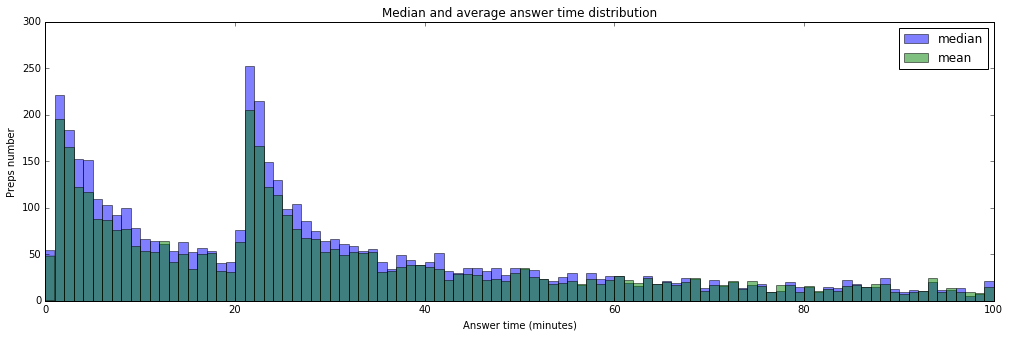

In [52]:
MAX_VALUE = 100
print "Распределение среднего и медианного времени ответов (отрезаем хвост после {0})".format(MAX_VALUE)

show_usual_stats(median_answer_time.values)

plt.figure(figsize=(17,5))
plt.hist(median_answer_time.values, bins = 100, alpha=0.5, label='median', range = (0,MAX_VALUE))
plt.hist(mean_answer_time.values, bins = 100, alpha=0.5, label='mean', range = (0,MAX_VALUE))
plt.legend(loc='upper right')
plt.title('Median and average reply time distribution')
plt.xlabel('Reply time (minutes)')
plt.ylabel('Preps number')
plt.show()

**Загадка:** <br>Откуда взялся такой жирный пик на 23-25 минутах?<br>
**Отгадка:** <br> 
Это реакция на смс. Когда спецу приходит приглашение, сначала отправляются бесплатные уведомления - email и пуш. И если в течение 20 минут не было реакции (спец увидел заказаи и нажал в нем что-то), то отправляется еще и смс. Смс - это мощный пинок, пробивающий даже тех, кому лень. 

(стоит иметь в виду, что с 21.04 13:40 активен [АБ-тест](https://repetitors.info/admin/aforum/?t=155747), который отменяет часть СМС)

## Сколько надо приглашений, чтобы считать, что отвечаемость есть и она адекватна

Концептуально мы хотели держать два числа: метрика + наша уверенность в том, что она такая.
Видимо "уверенность" это и есть количество приглашений. Чем их больше, тем уверенность выше. Нужен какой-то график "уверенности" типа арктангенса или тупо линейный. Короче понимать при каком числе приглашений это прямо устоявшаяся статистика, при каком числе приглашений это просто случайное число.<br>

Возьмем только спецов, у которых не менее 20 ответов на приглашения, чтобы посмотреть, какая бывает динамика по времени

In [53]:
INVITES_N = 20

## 1. 
Посчитаем изменение медианы времени ответа у каждого спеца и выведем это на один график 
(я попробовала также среднее и стандартное отклонение, там совсем дикость). <br>
Хотим посмотреть, а медианное время вообще хоть у кого-то устаканивается, или всегда дико скачет?
<br><br>
Ограничила потолок графика 100 минутами, иначе есть гиганские выбросы (90 дней например), из-за которых ничего не видно.

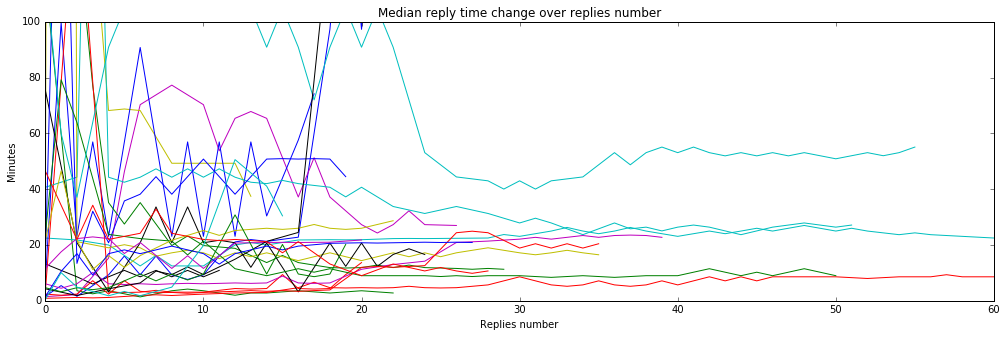

In [38]:
plt.figure(figsize=(17,5))
plt.xlim(0, 60)
plt.ylim(0, 100)

preps_filtered = df_preps_answers_count[df_preps_answers_count >= INVITES_N]

for prep_id in preps_filtered.index[:25]: 
    prep_minutes_diff = df_answers_diffs.loc[prep_id].sort_index(level = 'invite_dt')['minutes_diff']
    x = range(len(prep_minutes_diff)) 
    y = []
    for i in x:
        y.append(prep_minutes_diff[:i+1].median())
    plt.plot(x,y)

plt.title("Median reply time change over invites number")
plt.xlabel("Invites number")
plt.ylabel("Minutes")
plt.show()

Здесь выборка всего из 25 человек, чтобы посмотреть глазками.<br>
По графику видно лишь то, что есть некоторые спецы, у которых медиана выравнивается и становится красиво-плавной. Особенно у тех, кто ответил более 30 раз. 

## 2. 
Посчитаем разницу между текущей медианой времени по спецу и предыдущей (то есть график модуля разницы между медианой времени на день N, и день N-1). <br>
Надежда на то, что со временем у всех спецов этот график будет ползти около нуля

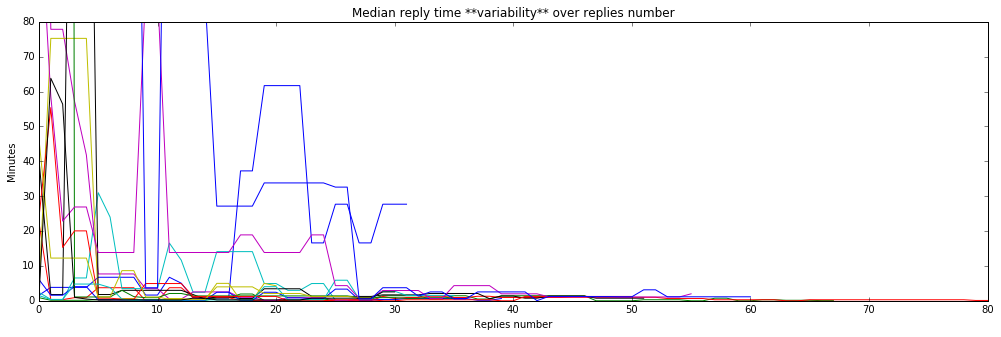

In [39]:
plt.figure(figsize=(17,5))
plt.xlim(0, 80)
plt.ylim(0, 80)

preps_filtered = df_preps_answers_count[df_preps_answers_count >= INVITES_N]

for prep_id in preps_filtered.index[:15]:    
    prep_minutes_diff = df_answers_diffs.loc[prep_id].sort_index(level = 'invite_dt')['minutes_diff']
    x = range( len(prep_minutes_diff)) # 
    y = []
    previous_median = 0
    for i in x:
        current_median = prep_minutes_diff[:i+1].median()
        median_diff = abs(current_median - previous_median)
        y.append(median_diff)
        previous_median = current_median
    plt.plot(x,y)

plt.title("Median reply time **variability** over invites number")
plt.xlabel("Invites number")
plt.ylabel("Minutes")
plt.show()

Действительно есть те, у кого этот график ползёт у нуля, надо понять, какой процент таких спецов, и построить по ним некий обобщенный график.
**<span style="color:red">TODO</span>**

## 3.
Смотрим на процент ответов по препам, изменяющийся со временем

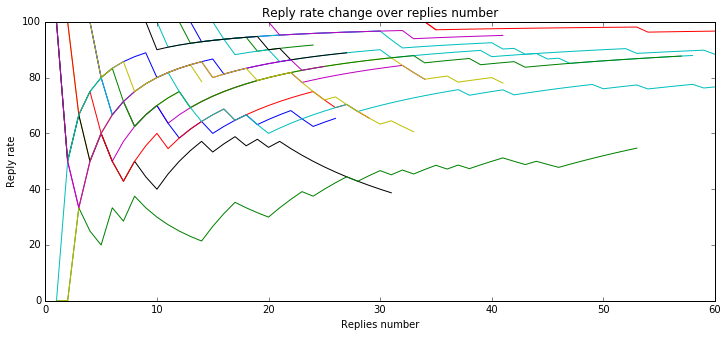

In [40]:
plt.figure(figsize=(12,5))
plt.xlim(0, 60)

preps_filtered = df_preps_answers_count[df_preps_answers_count >= INVITES_N]

for prep_id in preps_filtered.index[:20]:   
    cols = ['order_id', 'invite_dt', 'answer_id']
    some_prep_df = df[df['prep_id'] == prep_id][cols].groupby(['order_id']).first().sort_index(level = 'invite_dt')
    x = range(1, len(some_prep_df))
    y = []
    for i in x:
        some_prep_df_part = some_prep_df[:i]
        y.append(len(some_prep_df_part[some_prep_df_part['answer_id'] > 0]) * 100.0 / i)
    plt.plot(x,y)

plt.title("Reply rate change over invites number")
plt.xlabel("Invites number")
plt.ylabel("Reply rate")
plt.show()

Ничего не понятно, но надо было убедиться. Кажется, что эта метрика у многих всё-таки выправляется и не так сильно скачет, как медиана времени. <br>
Смотрим следующий график.

## 4.
Посчитаем разницу между текущим процентом отвечаемости по спецу и предыдущим (то есть график модуля разницы между процентом отвечаемости на день N, и день N-1).<br>
Надежда на то, что со временем у всех спецов этот график будет ползти около нуля 

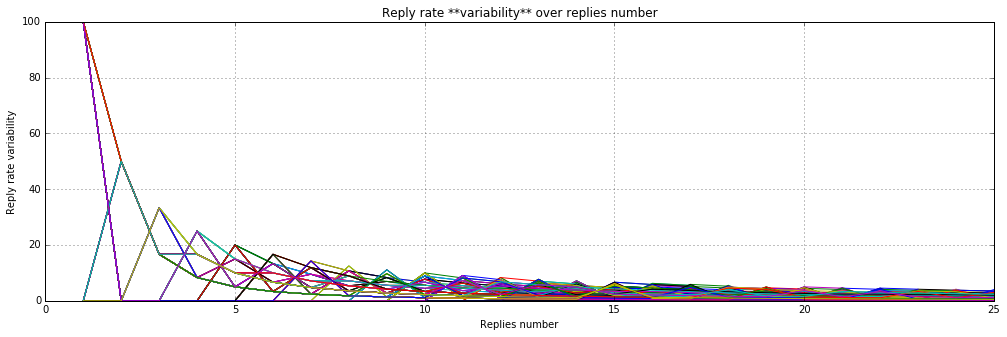

In [43]:
plt.figure(figsize=(17,5))
plt.xlim(0, 25)

preps_filtered = df_preps_answers_count[df_preps_answers_count >= INVITES_N]

for prep_id in preps_filtered.index:   
    cols = ['order_id', 'invite_dt', 'answer_id']
    some_prep_df = df[df['prep_id'] == prep_id][cols].groupby(['order_id']).first().sort_index(level = 'invite_dt')
    x = range(1, len(some_prep_df))
    y = []
    previous_percent = 0
    for i in x:
        some_prep_df_part = some_prep_df[:i]
        current_percent = len(some_prep_df_part[some_prep_df_part['answer_id'] > 0]) * 100.0 / i
        percent_diff = abs(current_percent - previous_percent)
        y.append(percent_diff)
        previous_percent = current_percent
    plt.plot(x,y)

plt.title("Reply rate **variability** over invites number")
plt.xlabel("Invites number")
plt.ylabel("Reply rate variability")
plt.grid(True)
plt.show()

Так-так, посмотрим пристальнее на участок после 5-го ответа:

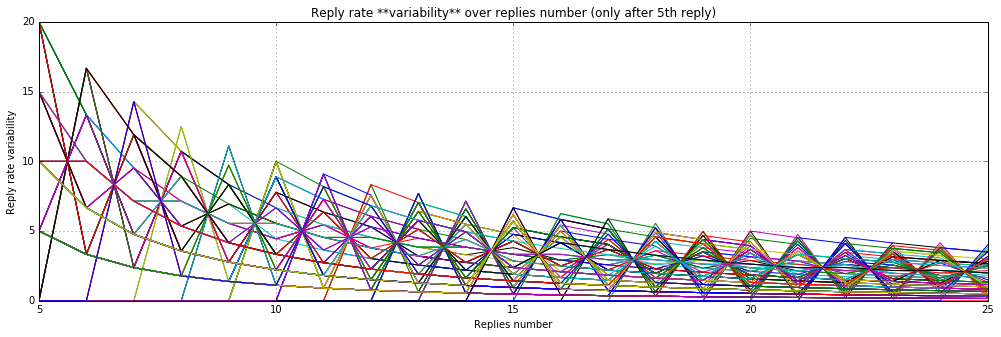

In [44]:
INVITES_N = 20

plt.figure(figsize=(17,5))
plt.xlim(5, 25)
plt.ylim(0, 20)

preps_filtered = df_preps_answers_count[df_preps_answers_count >= INVITES_N]

for prep_id in preps_filtered.index:   
    cols = ['order_id', 'invite_dt', 'answer_id']
    some_prep_df = df[df['prep_id'] == prep_id][cols].groupby(['order_id']).first().sort_index(level = 'invite_dt')
    x = range(1, len(some_prep_df))
    y = []
    previous_percent = 0
    for i in x:
        some_prep_df_part = some_prep_df[:i]
        current_percent = len(some_prep_df_part[some_prep_df_part['answer_id'] > 0]) * 100.0 / i
        percent_diff = abs(current_percent - previous_percent)
        y.append(percent_diff)
        previous_percent = current_percent
    plt.plot(x,y)

plt.title("Reply rate **variability** over invites number (only after 5th invite)")
plt.xlabel("Invites number")
plt.ylabel("Reply rate variability")
plt.grid(True)
plt.show()

Красота.<br>
Кажется, этот график помогает ответить на вопрос, после какого ответа метрика отвечаемости "устаканивается". 

- Берем спецов, у которых как минимум 20 ответов на приглашения.
- Считаем по каждому спецу процент ответов после каждого нового приглашения. (У всех эта цифра начинается либо с 0%, либо с 100%. Со вторым ответом появляются те, у кого 50%. И дальше уже намного больше разнообразия.
- Считаем по каждому спецу, на сколько процентных пунктов изменилась его отвечаемость. Предполагаем, что чем больше ответов, тем меньше будет скакать эта метрика.

И получаем, что начиная с 5-го ответа метрика отвечаемости скачет в пределах 20%, и чем дальше - тем меньше скачки. После 10-го ответа скачки в пределах 10%. После 19-го в пределах 5%. <br>

Нюанс: здесь учитывается вся история ответов спеца. А что если учитывать не все ответы, а только последние N?? Надо понять N. **<span style="color:red">TODO</span>**

## 5.
Выше мы смотрели на графики каждого спеца по отдельности. Попробуем теперь аппроксимировать и посмотреть на "среднее". <br>
На самом деле это единственный график, на который теперь стоит смотреть. Предыдущие отражают лишь путь, как я пришла к этому.<br>
<br>
Сначала смотрим только спецов, у которых 20+ ответов. Таких спецов всего 190 человек (это 0.8% выборки). Но на них хорошо видно динамику.

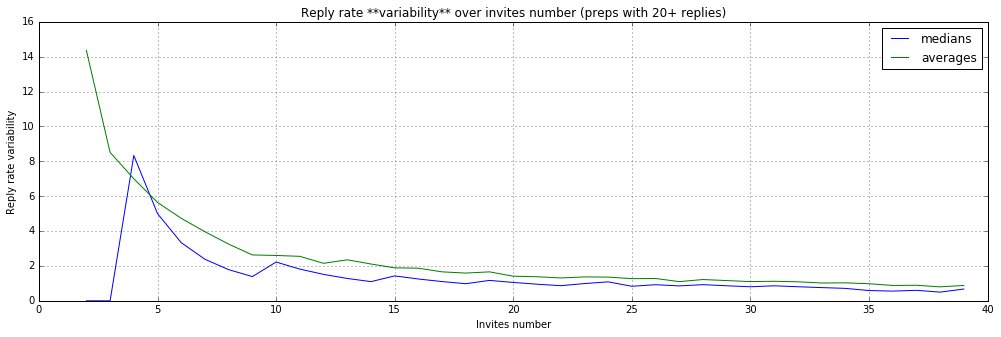

In [113]:
INVITES_N = 20
MAX_REPLY_NUMBER = 40

x = range(1, MAX_REPLY_NUMBER)
preps_reply_rates_by_reply_number = {} 
for i in x:
    preps_reply_rates_by_reply_number[i] = []

plt.figure(figsize=(17,5))
plt.xlim(0, MAX_REPLY_NUMBER)

preps_filtered = df_preps_answers_count[df_preps_answers_count >= INVITES_N]

for prep_id in preps_filtered.index:   
    cols = ['order_id', 'invite_dt', 'answer_id']
    some_prep_df = df[df['prep_id'] == prep_id][cols].groupby(['order_id']).first().sort_index(level = 'invite_dt')
    previous_percent = 0
    for i in range(1, min(MAX_REPLY_NUMBER, len(some_prep_df))):
        some_prep_df_part = some_prep_df[:i]
        current_percent = len(some_prep_df_part[some_prep_df_part['answer_id'] > 0]) * 100.0 / i
        percent_diff = abs(current_percent - previous_percent)
        preps_reply_rates_by_reply_number[i].append(percent_diff)
        previous_percent = current_percent
    
# берем МЕДИАНУ разниц по каждому N-ому ответу
medians_y = []
for i in x[1:]:
    medians_y.append(percentile(sorted(preps_reply_rates_by_reply_number[i]), 0.5))  
plt.plot(x[1:], medians_y, label='medians')
    
# берем СРЕДНЕЕ разниц по каждому N-ому ответу
averages_y = []
for i in x[1:]:
    averages_y.append(avg(preps_reply_rates_by_reply_number[i]))
plt.plot(x[1:], averages_y, label='averages')

plt.title("Reply rate **variability** over invites number (preps with 20+ replies)")
plt.xlabel("Invites number")
plt.ylabel("Reply rate variability")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

График начинается не с 0 и даже не с 1, потому что изменяемость метрики можно посчитать только после второго инвайта. <br>
Медиана на 2 и 3 ответах равна 0 потому, что больше половины спецов либо вообще не отвечают на приглашения (и тогда отвечаемость стабильно = 0), либо отвечают на все (и тогда отвечаемость стабильно = 1). 
<br><br>
Расширяем выборку! Теперь смотрим тех, у кого 4+ инвайтов (а не 20+ ответов). 

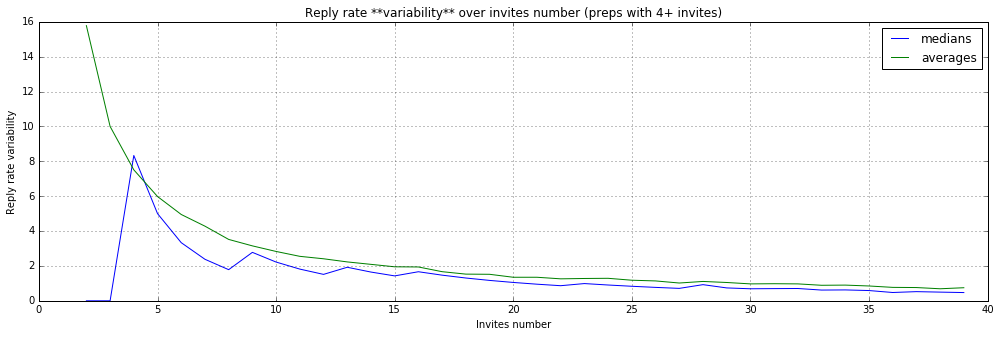

In [114]:
INVITES_N = 4
MAX_REPLY_NUMBER = 40

x = range(1, MAX_REPLY_NUMBER)
preps_reply_rates_by_reply_number = {} 
for i in x:
    preps_reply_rates_by_reply_number[i] = []

plt.figure(figsize=(17,5))
plt.xlim(0, MAX_REPLY_NUMBER)

preps_filtered = df_preps_invites_count[df_preps_invites_count >= INVITES_N]

for prep_id in preps_filtered.index:   
    cols = ['order_id', 'invite_dt', 'answer_id']
    some_prep_df = df[df['prep_id'] == prep_id][cols].groupby(['order_id']).first().sort_index(level = 'invite_dt')
    previous_percent = 0
    for i in range(1, min(MAX_REPLY_NUMBER, len(some_prep_df))):
        some_prep_df_part = some_prep_df[:i]
        current_percent = len(some_prep_df_part[some_prep_df_part['answer_id'] > 0]) * 100.0 / i
        percent_diff = abs(current_percent - previous_percent)
        preps_reply_rates_by_reply_number[i].append(percent_diff)
        previous_percent = current_percent
    
# берем МЕДИАНУ разниц по каждому N-ому ответу
medians_y = []
for i in x[1:]:
    medians_y.append(percentile(sorted(preps_reply_rates_by_reply_number[i]), 0.5))  
plt.plot(x[1:], medians_y, label='medians')
    
# берем СРЕДНЕЕ разниц по каждому N-ому ответу
averages_y = []
for i in x[1:]:
    averages_y.append(avg(preps_reply_rates_by_reply_number[i]))
plt.plot(x[1:], averages_y, label='averages')

plt.title("Reply rate **variability** over invites number (preps with 4+ invites)")
plt.xlabel("Invites number")
plt.ylabel("Reply rate variability")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Ура! Динамика почти не отличается от выборки, где 20+ ответов.
<br><br>
А на каком количестве данных построен график выше?

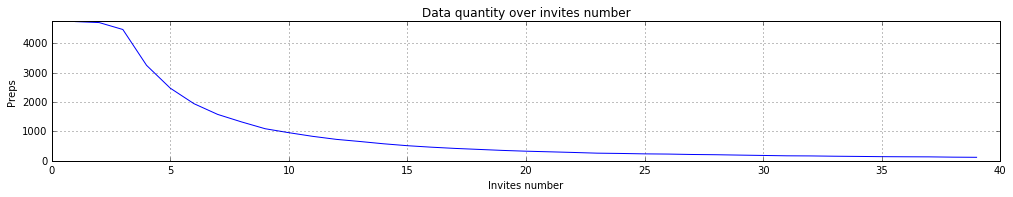

In [121]:
datalen_y = []
for i in x:
    datalen_y.append(len(preps_reply_rates_by_reply_number[i]))  
    
plt.figure(figsize=(17,2.5))
plt.ylim(0, max(datalen_y)+10)
plt.plot(x, datalen_y)

plt.title("Data quantity over invites number")
plt.xlabel("Invites number")
plt.ylabel("Preps")
plt.grid(True)
plt.show()

На входе получается 4739 спецов, то есть 21% от изначальной выборки. Напомню, это те, кто получил 4+ инвайтов. (поэтому такое плавное начало на участке 1-3 (кажется, у меня есть какая-то ошибка, потому что график должен быть совсем плоским на участке 1-4, а это не так)!!!!!!
<br>
#### Какой можно сделать вывод?
Здесь я бы ориентировалась на среднее, а не на медиану, потому что выбросы тоже важны, особенно на начальном участке. <br>
Начиная с 5 приглашения метрика отвечаемости скачет в средних пределах 6%. Если для нас это допустимо, то можем начинать учитывать отвечаемость после 5 инвайта. И соответственно, чем дальше, тем меньше пределы скачков.

## 6. 
Посмотрим на такой же график по медианному/среднему времени ответа.<br>
Тут уже важно число ответов, а не инвайтов, потому что если было 20 инвайтов, но ни одного ответа, то мы ничего не посчитаем.

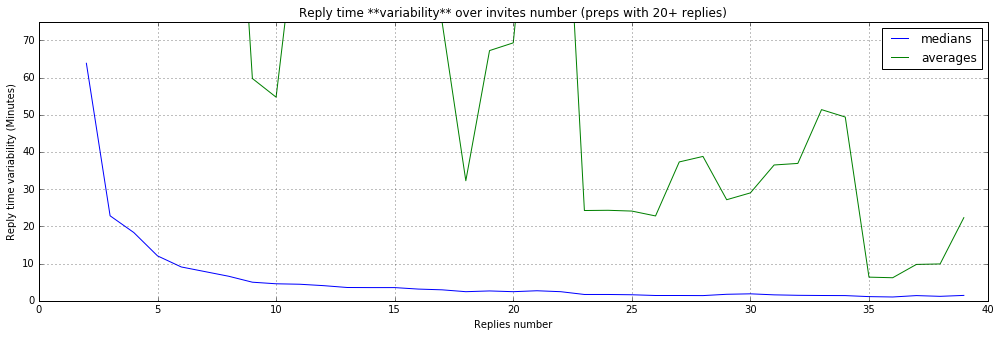

In [133]:
INVITES_N = 4
MAX_REPLY_NUMBER = 40

x = range(1, MAX_REPLY_NUMBER)
preps_reply_time_by_reply_number = {} 
for i in x:
    preps_reply_time_by_reply_number[i] = []

plt.figure(figsize=(17,5))
plt.xlim(0, MAX_REPLY_NUMBER)
plt.ylim(0, 75) #1600

preps_filtered = df_preps_answers_count[df_preps_answers_count >= INVITES_N]

for prep_id in preps_filtered.index:    
    prep_minutes_diff = df_answers_diffs.loc[prep_id].sort_index(level = 'invite_dt')['minutes_diff']
    previous_median = 0
    for i in range(1, min(MAX_REPLY_NUMBER, len(prep_minutes_diff))):
        current_median = prep_minutes_diff[:i+1].median()
        median_diff = abs(current_median - previous_median)
        preps_reply_time_by_reply_number[i].append(median_diff)
        previous_median = current_median
    
# берем МЕДИАНУ разниц по каждому N-ому ответу
medians_y = []
for i in x[1:]:
    medians_y.append(percentile(sorted(preps_reply_time_by_reply_number[i]), 0.5))  
plt.plot(x[1:], medians_y, label='medians')
    
# берем СРЕДНЕЕ разниц по каждому N-ому ответу
averages_y = []
for i in x[1:]:
    averages_y.append(avg(preps_reply_time_by_reply_number[i]))
plt.plot(x[1:], averages_y, label='averages')

plt.title("Reply time **variability** over invites number (preps with 20+ replies)")
plt.xlabel("Replies number")
plt.ylabel("Reply time variability (Minutes)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

В среднем слишком большие выбросы. Попробуем посчитать усеченное среднее, где отрежем 5% сверху.

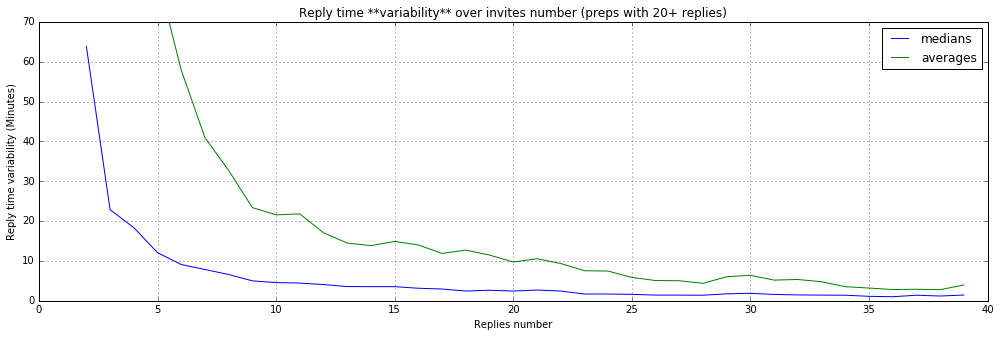

In [142]:
INVITES_N = 4
MAX_REPLY_NUMBER = 40

x = range(1, MAX_REPLY_NUMBER)
preps_reply_time_by_reply_number = {} 
for i in x:
    preps_reply_time_by_reply_number[i] = []

plt.figure(figsize=(17,5))
plt.xlim(0, MAX_REPLY_NUMBER)
plt.ylim(0, 70) 

preps_filtered = df_preps_answers_count[df_preps_answers_count >= INVITES_N]

for prep_id in preps_filtered.index:    
    prep_minutes_diff = df_answers_diffs.loc[prep_id].sort_index(level = 'invite_dt')['minutes_diff']
    previous_median = 0
    for i in range(1, min(MAX_REPLY_NUMBER, len(prep_minutes_diff))):
        current_median = prep_minutes_diff[:i+1].median()
        median_diff = abs(current_median - previous_median)
        preps_reply_time_by_reply_number[i].append(median_diff)
        previous_median = current_median
    
# берем МЕДИАНУ разниц по каждому N-ому ответу
medians_y = []
for i in x[1:]:
    medians_y.append(percentile(sorted(preps_reply_time_by_reply_number[i]), 0.5))  
plt.plot(x[1:], medians_y, label='medians')
    
# берем УСЕЧЕННОЕ СРЕДНЕЕ разниц по каждому N-ому ответу
TRUNCATION = 0.95

averages_y = []
for i in x[1:]:
    last_truncated_index = int(len(preps_reply_time_by_reply_number[i]) * TRUNCATION)
    truncated_list = sorted(preps_reply_time_by_reply_number[i])[:last_truncated_index]
    averages_y.append(avg(truncated_list))
plt.plot(x[1:], averages_y, label='averages')

plt.title("Reply time **variability** over invites number (preps with 20+ replies)")
plt.xlabel("Replies number")
plt.ylabel("Reply time variability (Minutes)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Ну вот уже терпимо. Здесь я ограничила ось Y сверху 70 минутами (но можно иметь в виду, что среднее там начинается с 610 минут).
#### Выводы:
После 5 ответов, медиана времени ответа колеблется уже в пределах 12 минут. Это медиана медиан :) Если смотреть по усеченному среднему от медиан времени, то тут уже метрика колеблется в пределах 70 минут. Кажется, это можно назвать устаканиваением.<br>
<br>
#### Next step:
Осталось понять, а сколько времени клиент вообще готов ждать ответ. Надо посмотреть зависимость между вероятностью назначения и скоростью ответа. Там будет видно сколько клиент не готов ждать (после какого времени он уже не выберет спеца), а сколько ждать оптимально (ответ спеца в этот период почти точно приведёт к его назначению). <br>


Что дальше:

- посмотреть и на % отвеченных и на время ответа. Понять сводится ли это к одному числу. 

- подключаем компонент времени. Как вообще эти приглашения распределены по времени? Можно ли брать последние 10 с одним весом, предпоследние 10 с другим весом и всё это суммировать? Есть ли такое, что спец отвечал хорошо, потом скатывается и отвечает плохо, а потом опять отвечает хорошо.

- Надо бы посмотреть зависимость между вероятностью назначения и скоростью ответа. Там будет видно сколько клиент не готов ждать (после какого времени он уже не выберет спеца), а сколько ждать оптимально (ответ спеца в этот период почти точно приведёт к его назначению).